#e4 wristband from data collection to classification to visualization
e4_end_to_end.ipynb
This notebook is specific to the e4 data set and was used to generate the figures and results presented in tbd paper.  This was forked from the load_dataset_demo.ipynb which is also in this repository and is likely to be updated more regularly since it supports multiple data sets.

For this version the non-e4 support has been deleted and significant logging functions have been added.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* 



In [1]:
#mount google drive in colab session
#enter path to where the top-level git repo was cloned
my_path = '/content/drive/My Drive/Colab Notebooks/imics_lab_repositories/load_data_time_series_dev'

#Imports

In [2]:
import os
import shutil
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


# Get environment info if colab plus a few helper functions

In [3]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    if 'google.colab' in str(get_ipython()):
        my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
        my_name += ".ipynb"
    else:
        # seems a bit complicated to get filename in any environment
        # and hard coding the name here will make this not portable
        # this should elminate the failure in non-colab instances though
        my_name = 'Executing local file, not running in CoLab'
    return my_name
#start output file with unique name - important for colab runs
def start_logfiles(base_name = "unnamed", first_line = "nothing here"):
    """creates file and writes colab environment info, returns full filename
    which is concatenation of path, base_name, and current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

#Get the numpy arrays using e4_load_dataset.py

In [4]:
DATASET = "e4_Nov2019" 
full_filename = my_path+os.path.join('/HAR/e4_wristband_Nov2019/'+'e4_load_dataset.py')
shutil.copy(full_filename,'e4_load_dataset.py')
from e4_load_dataset import e4_load_dataset
x_train, y_train, x_validate, y_validate, x_test, y_test = e4_load_dataset(incl_val_group = True, incl_xyz_accel= True)
t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
kernel_size = 17
num_filters = 50
BATCH_SIZE = 32
NUM_EPOCHS = 30 # with the small training set 100 epochs overfits badly
print(get_shapes([x_train, y_train, x_validate, y_validate, x_test, y_test]))
log_info = get_shapes([x_train, y_train, x_validate, y_validate, x_test, y_test])

Processing  1574621345_A01F11.zip
Unzipping e4 file in local directory /content/temp
/content/temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574621375.17 Sun, 24 Nov 2019 18:49:35
1 1574621774.22 Sun, 24 Nov 2019 18:56:14
Label Counts
 Upstairs      6208
Downstairs    5889
Undefined     5405
Name: label, dtype: int64
No NaN entries found
shapes call broke when making the function - not sure why
Processing  1574622389_A01F11.zip
Unzipping e4 file in local directory /content/temp
/content/temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 19:06:29
File end time   =  Sun, 24 Nov 2019 19:15:03
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574622432.21 Sun, 24 Nov 2019 19:07:12
1 1574622822.72 Sun, 24 Nov 2019 19:13:42
Label Counts
 Walking      5793
Jogging      5792
Undefine

# Function: evaluate_model builds and trains Keras 1D CNN model 
topology and good article [here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [5]:
def evaluate_model(trainX, trainy, validationX, validationy, 
                    BATCH_SIZE=32, NUM_EPOCHS=25,
                    my_filters = 50, my_kernel_size = 16):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu',input_shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(
        trainX,trainy,
        #steps_per_epoch=trainX.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 0, #0 = silent, 1 = progress bar, 2 = one line per epoch
        validation_data=(validationX,validationy),
        #validation_steps=validationX.shape[1]//BATCH_SIZE
        shuffle = True)
    model.save('my_1D_CNN_model')
    return history

#Function: run_model loads model and predicts using the test dataset

In [6]:
def run_model(testX, testy):
    model = keras.models.load_model('my_1D_CNN_model')
    predictions = model.predict(testX, verbose=0,batch_size=32)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_temp = np.argmax(testy, axis=-1)
    return (accuracy_score(y_temp, y_pred)),y_pred

#Loop train with validation \# repeats times
This generates accuracy list that can be easily imported in to Excel or LaTex. 
Results can be saved to mounted drive if desired.

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_e4_paper_Jul-06-2021_1745.txt
--- batch_size = 32 kernel_size = 17 num_epochs = 30

Pass number  1  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.884                                 Prediction accuracy: 0.970


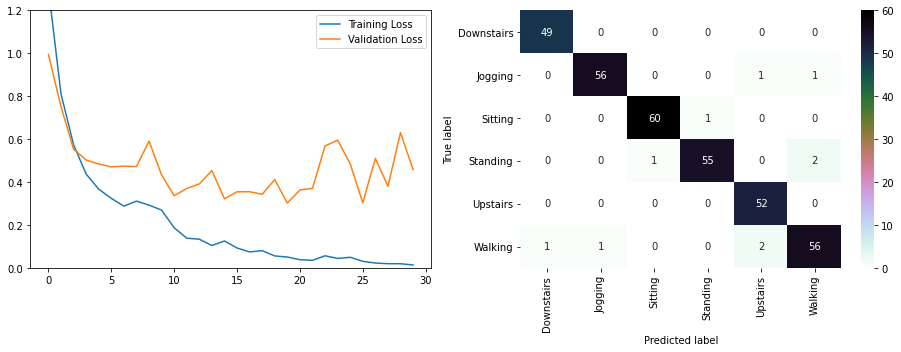

Pass number  2  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.933                                 Prediction accuracy: 0.970


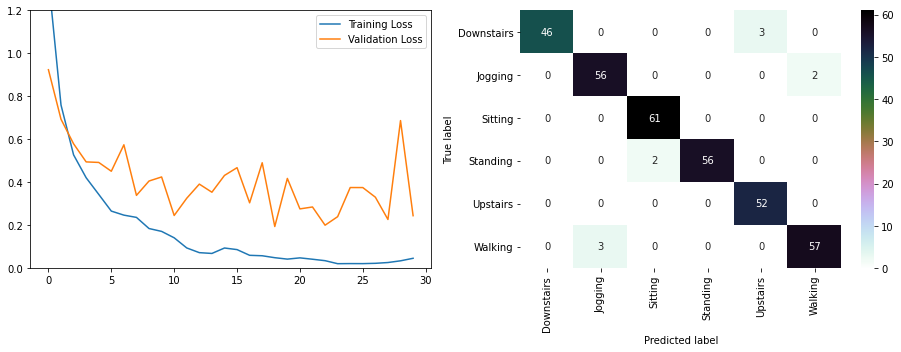

Pass number  3  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.860                                 Prediction accuracy: 0.976


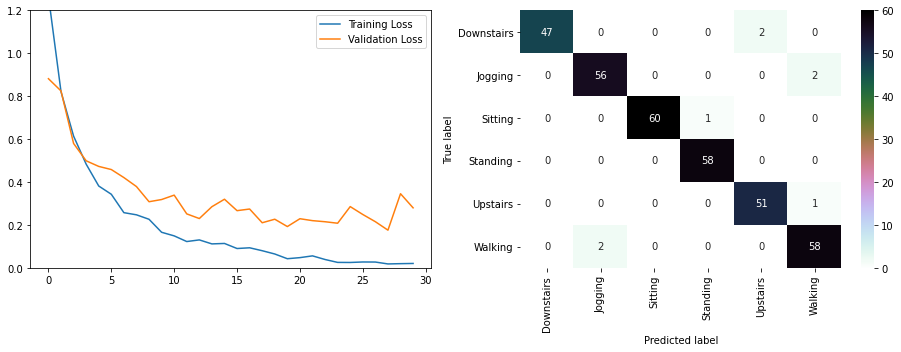

Pass number  4  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.906                                 Prediction accuracy: 0.929


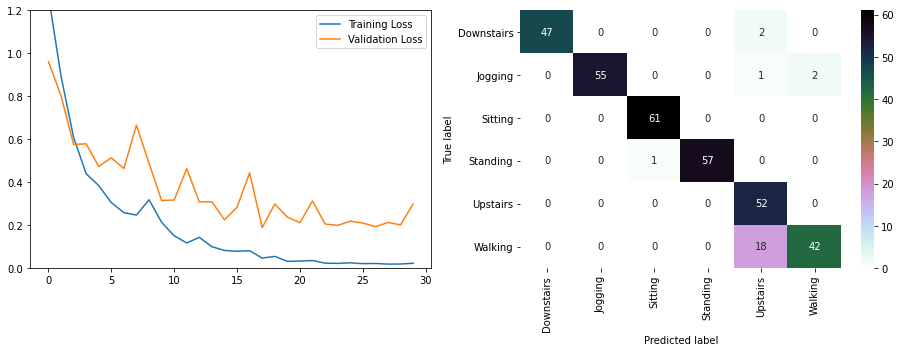

Pass number  5  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.802                                 Prediction accuracy: 0.929


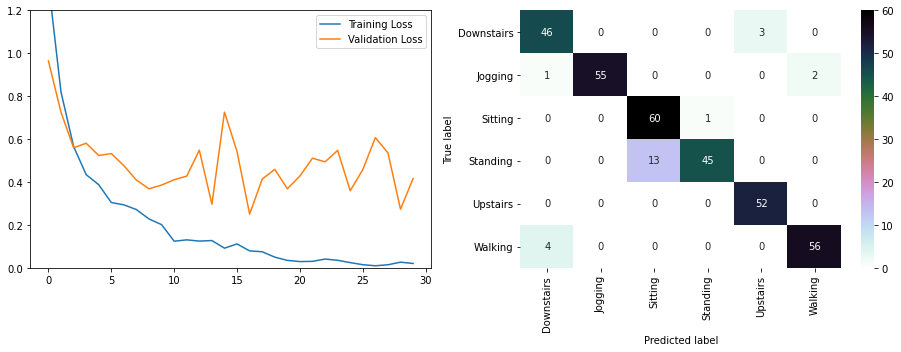

Pass number  6  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.918                                 Prediction accuracy: 0.970


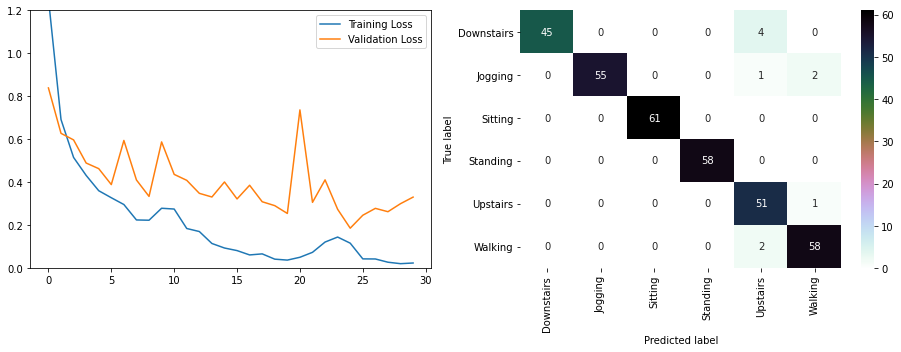

Pass number  7  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.936                                 Prediction accuracy: 0.976


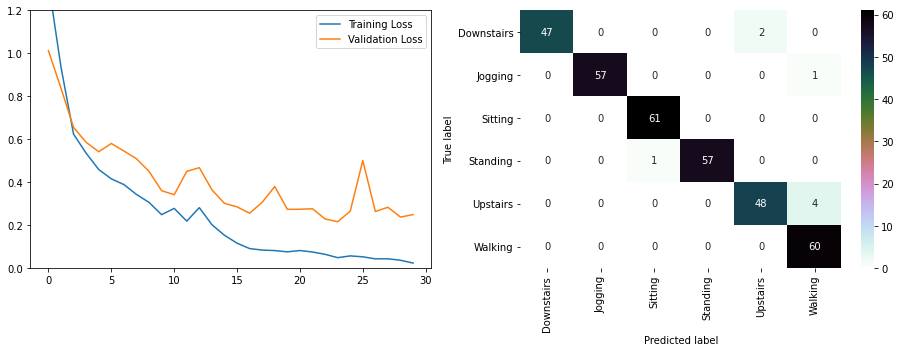

Pass number  8  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.827                                 Prediction accuracy: 0.932


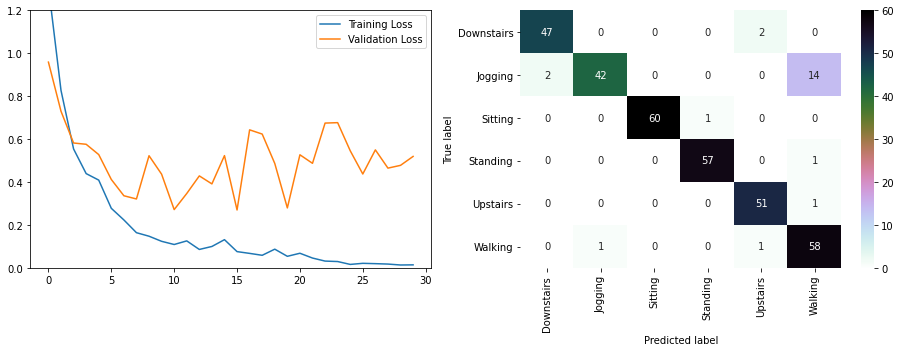

Pass number  9  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.933                                 Prediction accuracy: 0.959


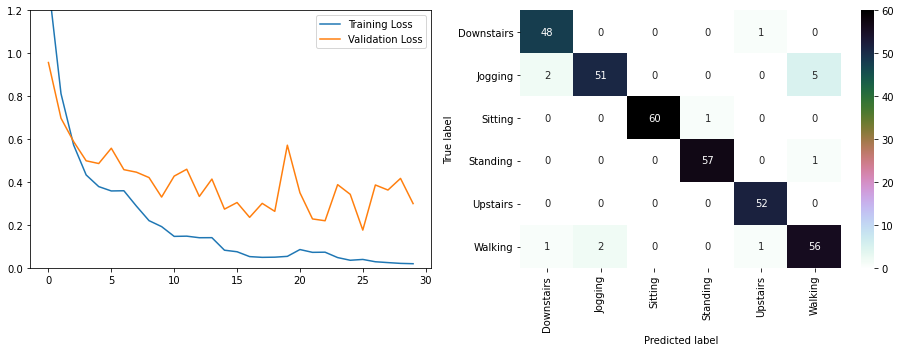

Pass number  10  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
           Validation accuracy: 0.936                                 Prediction accuracy: 0.973


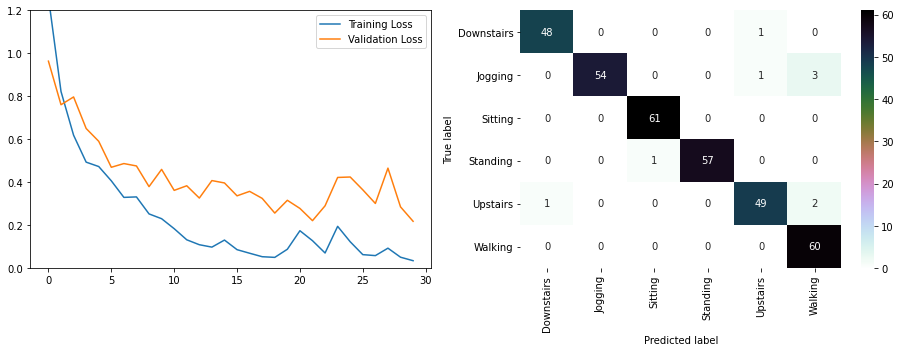

Accuracy,1,2,3,4,5,6,7,8,9,10,Avg
 Validation ,0.884,0.933,0.860,0.906,0.802,0.918,0.936,0.827,0.933,0.936,0.894
 Prediction ,0.970,0.970,0.976,0.929,0.929,0.970,0.976,0.932,0.959,0.973,0.959

              precision    recall  f1-score   support

  Downstairs       0.98      0.98      0.98        49
     Jogging       1.00      0.93      0.96        58
     Sitting       0.98      1.00      0.99        61
    Standing       1.00      0.98      0.99        58
    Upstairs       0.96      0.94      0.95        52
     Walking       0.92      1.00      0.96        60

    accuracy                           0.97       338
   macro avg       0.97      0.97      0.97       338
weighted avg       0.97      0.97      0.97       338

saving loss plot as /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_e4_paper_Jul-06-2021_1745_loss.pdf


In [8]:
repeats = 10;
save_log = True # True = write results to disk
log_full_fname = start_logfiles(base_name=DATASET+'_e4_paper',
                                first_line='e4_paper including component accel' + DATASET)

pass_info = "--- batch_size = " + str(BATCH_SIZE)
pass_info += " kernel_size = " + str(kernel_size)
pass_info += " num_epochs = " + str(NUM_EPOCHS) + "\n"
print (pass_info)
if save_log:
    with open(log_full_fname, "a") as file_object:
        file_object.write(log_info)
        file_object.write(pass_info)
best_acc = 0
for repeat_num in range(repeats):  #rerun current config
    print("Pass number ", repeat_num + 1, " of ",repeats)
    history = evaluate_model(x_train, y_train, x_validate, y_validate,
                                BATCH_SIZE, NUM_EPOCHS, my_filters = num_filters,
                                my_kernel_size = kernel_size)
    v_acc = history.history['val_accuracy'][-1]
    if (v_acc > best_acc):
        best_acc = v_acc
    #Now run trained model against test set
    acc, y_pred = run_model(x_test, y_test)
    my_title = ('           Validation accuracy: {0:.3f}'.format(v_acc)+
                '                                 '+
                'Prediction accuracy: {0:.3f}'.format(acc))
    print (my_title)
    #plot loss and confusion matrix side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,5))
    #fig.suptitle('Tight layout makes title overlap')
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.legend()
    #ax1.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
    ax1.axis(ymin=0,ymax=1.2)
    y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
    cm = confusion_matrix(y_test_act, y_pred)
    cm_df = pd.DataFrame(cm,
                        index = t_names, 
                        columns = t_names)
    g2 = sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    #col_sep = '&' # for import as LaTeX table
    #end_line = '\\\\ \\hline\n' # end of table row with underline for latex
    col_sep = ',' # for csv
    end_line = '\n' # for csv
    if (repeat_num == 0):
        header = 'Accuracy'+ col_sep + str(repeat_num + 1)
        val_acc = 'Validation '+ col_sep +'%0.3f' % history.history['val_accuracy'][-1]
        cumm_val_acc = history.history['val_accuracy'][-1]
        pred_acc = 'Prediction ' + col_sep + '{0:.3f}'.format(acc)
        cumm_run_acc = acc #total acc for quick avg calc
    else:
        header += col_sep + str(repeat_num + 1)
        val_acc += col_sep + '%0.3f' % history.history['val_accuracy'][-1]
        cumm_val_acc += history.history['val_accuracy'][-1]
        pred_acc += col_sep + '{0:.3f}'.format(acc)
        cumm_run_acc += acc
header += col_sep + 'Avg' + end_line
val_acc += col_sep + '{0:.3f}'.format(cumm_val_acc/repeats)+ end_line
pred_acc += col_sep + '{0:.3f}'.format(cumm_run_acc/repeats)+ end_line
print (header, val_acc, pred_acc)
# note this prints the classification report for the last run, not all repeats
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
c_rpt = classification_report(y_test_act, y_pred, target_names=t_names)
print (c_rpt)
if save_log:
    with open(log_full_fname, "a") as file_object:
            file_object.write(val_acc)
            file_object.write(pred_acc)
            file_object.write(c_rpt)
    #save the last plot as pdf
    full_fig_fname = log_full_fname.split('.')[0] + '_loss.pdf'
    print("saving loss plot as",full_fig_fname)
    fig.savefig(full_fig_fname,format='pdf')

#Show and Save Final Validation Accuracy and Loss Curve 

e4_Nov2019 1D CNN
Final Validation Accuracy: 0.936


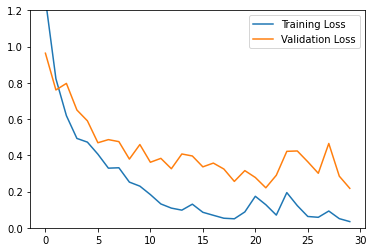

In [9]:
print(DATASET, "1D CNN")
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
plt.legend()
plt.show()

In [10]:
#save the loss plot as pdf
full_fig_fname = log_full_fname.split('.')[0] + '_loss.pdf'
print("saving loss plot as",full_fig_fname)
fig.savefig(full_fig_fname,format='pdf')

saving loss plot as /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_e4_paper_Jul-06-2021_1745_loss.pdf


# Show and Save Final Confusion Matrix and Model Info

Prediction accuracy: 0.973
              precision    recall  f1-score   support

  Downstairs       0.98      0.98      0.98        49
     Jogging       1.00      0.93      0.96        58
     Sitting       0.98      1.00      0.99        61
    Standing       1.00      0.98      0.99        58
    Upstairs       0.96      0.94      0.95        52
     Walking       0.92      1.00      0.96        60

    accuracy                           0.97       338
   macro avg       0.97      0.97      0.97       338
weighted avg       0.97      0.97      0.97       338



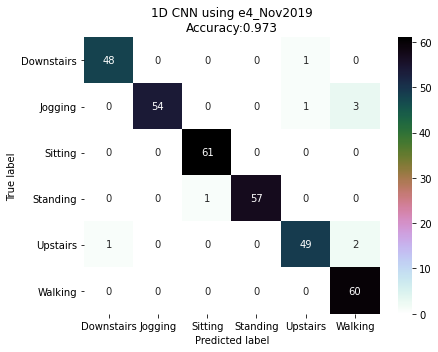

In [11]:
#predictions = model.predict(x_test, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
#y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
#y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
#return (accuracy_score(y_temp, y_pred)),y_pred
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
print(classification_report(y_test_act, y_pred, target_names=t_names))
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+DATASET+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

In [12]:
#save the confusion matrix figure as pdf
full_fig_fname = log_full_fname.split('.')[0] + '_cm.pdf'
print("saving cm plot as",full_fig_fname)
fig.savefig(full_fig_fname,format='pdf')

saving cm plot as /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_e4_paper_Jul-06-2021_1745_cm.pdf


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 80, 50)            3450      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 64, 50)            42550     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64, 50)            0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 32, 50)            0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               160100    
_________________________________________________________________
dense_39 (Dense)             (None, 6)               

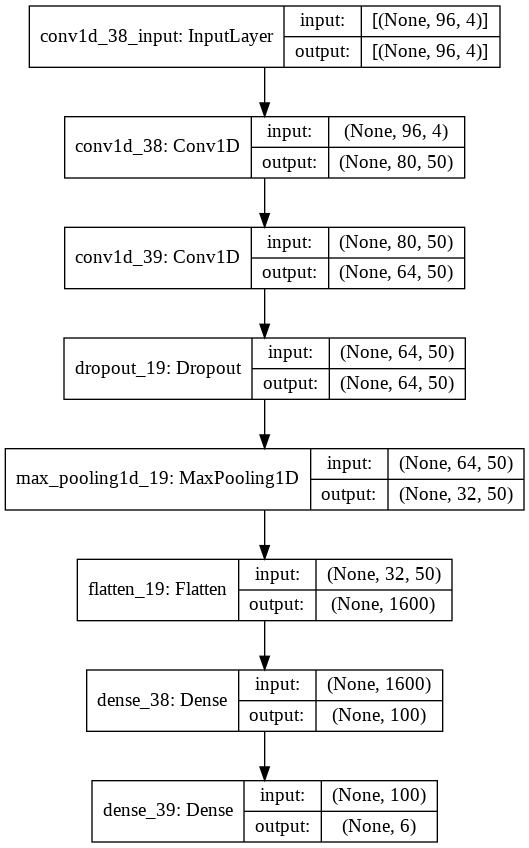

In [13]:
#save the model summary and model plot
model = keras.models.load_model('my_1D_CNN_model')
my_model = model.summary()
full_model_fname = log_full_fname.split('.')[0] + '_model.txt'
with open(full_model_fname, "a") as file_object:
    model.summary(print_fn=lambda x: file_object.write(x + '\n'))
    #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
#plot using keras function
#ref https://keras.io/api/utils/model_plotting_utils/
full_mplot_fname = log_full_fname.split('.')[0] + '_model.png'
tf.keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)

#Train and Save Final Model with all Structured Data

In [14]:
def final_model(trainX, trainy, 
                    BATCH_SIZE=32, NUM_EPOCHS=25,
                    my_filters = 50, my_kernel_size = 16):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu',input_shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(
        trainX,trainy,
        #steps_per_epoch=trainX.shape[1]//BATCH_SIZE,
        shuffle = True,
        epochs=NUM_EPOCHS,
        verbose = 1, #0 = silent, 1 = progress bar, 2 = one line per epoch
        #validation_data=(validationX,validationy),
        #validation_steps=validationX.shape[1]//BATCH_SIZE
        )
    model.save('e4_final_1D_CNN_model')
    return history

# Combine all Structured Data for Final Model Training

In [15]:
print('Starting shapes:')
print(get_shapes([x_train, y_train, x_validate, y_validate, x_test, y_test]))
x_all = np.vstack((x_train,x_validate))
x_all = np.vstack((x_all,x_test))
y_all = np.vstack((y_train,y_validate))
y_all = np.vstack((y_all,y_test))
print('Combined shapes:')
print(get_shapes([x_all,y_all]))

Starting shapes:
x_train shape is (380, 96, 4) data type is float64
y_train shape is (380, 6) data type is float64
x_validate shape is (329, 96, 4) data type is float64
y_validate shape is (329, 6) data type is float64
x_test shape is (338, 96, 4) data type is float64
y_test shape is (338, 6) data type is float64

Combined shapes:
x_all shape is (1047, 96, 4) data type is float64
y_all shape is (1047, 6) data type is float64



# Train and Save Final Model

In [16]:
kernel_size = 17
num_filters = 50
batch_size = 32
num_epochs = 30 # with the small training set 100 epochs overfits badly

history = final_model(x_all, y_all, BATCH_SIZE = batch_size,
                      NUM_EPOCHS = num_epochs, my_filters = num_filters,
                      my_kernel_size = kernel_size)

Epoch 1/30
33/33 [==============================] - 1s 26ms/step - loss: 1.0233 - accuracy: 0.5702
Epoch 2/30
33/33 [==============================] - 1s 25ms/step - loss: 0.5803 - accuracy: 0.8061
Epoch 3/30
33/33 [==============================] - 1s 25ms/step - loss: 0.3785 - accuracy: 0.8816
Epoch 4/30
33/33 [==============================] - 1s 24ms/step - loss: 0.3319 - accuracy: 0.8863
Epoch 5/30
33/33 [==============================] - 1s 26ms/step - loss: 0.2094 - accuracy: 0.9408
Epoch 6/30
33/33 [==============================] - 1s 26ms/step - loss: 0.1703 - accuracy: 0.9408
Epoch 7/30
33/33 [==============================] - 1s 24ms/step - loss: 0.1437 - accuracy: 0.9551
Epoch 8/30
33/33 [==============================] - 1s 25ms/step - loss: 0.0964 - accuracy: 0.9723
Epoch 9/30
33/33 [==============================] - 1s 25ms/step - loss: 0.0966 - accuracy: 0.9799
Epoch 10/30
33/33 [==============================] - 1s 25ms/step - loss: 0.0767 - accuracy: 0.9733
Epoch 11/

# Load the freeform walk file using e4_get_x_y_sub
y is all 'Not_Labeled and sub is all 1 per the associated cvs file

In [17]:
from e4_get_x_y_sub import get_X_y_sub
e4_flist = ['1574625540_A01F11.zip'] # Old main to Alkek and back
x_unl, y_unl, sub_unl, xys_info_unl = get_X_y_sub(zip_flist = e4_flist)
print(get_shapes([x_unl,y_unl,sub_unl]))

Processing  1574625540_A01F11.zip
Unzipping e4 file in local directory /content/temp
/content/temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 19:59:00
File end time   =  Sun, 24 Nov 2019 20:10:59
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574625579.24 Sun, 24 Nov 2019 19:59:39
1 1574626246.7 Sun, 24 Nov 2019 20:10:46
Label Counts
 Not_Labeled    21345
Undefined       1683
Name: label, dtype: int64
No NaN entries found
shapes call broke when making the function - not sure why
shapes call broke when making the function - not sure why
Final Label Counts
[['Not_Labeled' '665']]
e4 November 2019 zip files
1574625540_A01F11.zip
Time steps =96, Step =32, no resample
Final Shapes
shapes call broke when making the function - not sure why
x_unl shape is (665, 96, 4) data type is float64
y_unl shape is (665, 1) data type is <U11
sub_unl shape is (665, 1) data type is int64



# Load saved final model and generate predictions

In [18]:
model = keras.models.load_model('/content/e4_final_1D_CNN_model')
predictions = model.predict(x_unl, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis

In [19]:
# the one-hot encoding of the y_all here is meaningless since all labels are 'Not_Labeled'
# using output from train encoding, flip dictionary, use to build string version
# One-hot-encoding: category names -> int -> one-hot
str_to_key_dict = {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
key_to_str_dict = dict([(value, key) for key, value in str_to_key_dict.items()])
print(key_to_str_dict)
y_pred_labels = np.vectorize(key_to_str_dict.get)(y_pred)
unique, counts = np.unique(y_pred_labels, return_counts=True)
print("Final Label Counts")
print (np.asarray((unique, counts)).T)

{0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}
Final Label Counts
[['Downstairs' '66']
 ['Sitting' '85']
 ['Standing' '2']
 ['Upstairs' '162']
 ['Walking' '350']]


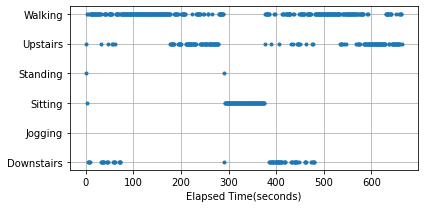

In [20]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(y_pred,linestyle="",marker=".")
#plt.title('Predicted Activity Labels')
ax.set_xlabel('Elapsed Time(seconds)')
ax.set_yticks(np.arange(6))
ax.set_yticklabels(['Downstairs', 'Jogging','Sitting', 'Standing', 'Upstairs', 'Walking'])
ax.grid()
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

In [21]:
#save the predicted activity plot as pdf
full_fig_fname = log_full_fname.split('.')[0] + '_pred.pdf'
print("saving prediction plot as",full_fig_fname)
fig.savefig(full_fig_fname,format='pdf')

saving prediction plot as /content/drive/My Drive/Colab_Run_Results/e4_Nov2019_e4_paper_Jul-06-2021_1745_pred.pdf


# Build vtt file with predicted activity labels
Example format from the beginning of recorded and captioned video<pre>
WEBVTT

1
00:00:03.840 --> 00:00:13.920
Lee Hinkle: Alright Suzy a quick rundown of some work i've been doing on load data time series, and specifically for this particular session i'm going to talk about.

2
00:00:14.490 --> 00:00:23.550
Lee Hinkle: Work on doing with the E4 wristband and so first off, let me kind of ground, you know and the load data time to us and the idea behind this is.
</pre>

In [22]:
START_SECS = 9 # this is the number of seconds of video before 1st label
STEP_SECS = 1 # this is the number of seconds until the next sample is evaluated
my_labels_vtt = 'WEBVTT\n\n' # header
my_labels_vtt += '1\n' # put in first line before labels
my_labels_vtt += '00:00:05.000 --> 00:00:10.000\n'
my_labels_vtt += 'activities shown are predictions by the trained model\n\n'

num_rows = np.shape(y_pred_labels)[0]
for i in range(2,num_rows):
    start = datetime.fromtimestamp(START_SECS + i*STEP_SECS)
    end = datetime.fromtimestamp(START_SECS+((i+1)*STEP_SECS))
    my_labels_vtt += str(i) + "\n"
    my_labels_vtt += start.strftime("%H:%M:%S.000")
    #my_labels_vtt += (time.strftime("%H:%M:%S.000", time.gmtime(START_TIME+i*STEP_SECS)))
    my_labels_vtt += " --> "
    my_labels_vtt += end.strftime("%H:%M:%S.000")
    #my_labels_vtt += (time.strftime("%H:%M:%S.000", time.gmtime(START_TIME+((i+1)*STEP_SECS))))
    my_labels_vtt += "\n"
    my_labels_vtt += y_pred_labels[i] + "\n\n"
#print(my_labels_vtt) # pretty long and makes scrolling a pain, should make 'head' type call
#acknowledgement https://stackoverflow.com/users/2146491/b%c5%82a%c5%bcej-michalik
#this is a 'tail' type call
print('\n'.join(my_labels_vtt.splitlines()[-20:]))

660
00:11:09.000 --> 00:11:10.000
Walking

661
00:11:10.000 --> 00:11:11.000
Upstairs

662
00:11:11.000 --> 00:11:12.000
Walking

663
00:11:12.000 --> 00:11:13.000
Walking

664
00:11:13.000 --> 00:11:14.000
Upstairs



# Write vtt file

In [23]:
full_vtt_fname = log_full_fname.split('.')[0] + '_cc.vtt'
text_file = open(full_vtt_fname, "w")
n = text_file.write(my_labels_vtt)
text_file.close()